In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import omegaconf
import os
%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'  # blue-teal
]

markers = [
    "P",
    "o",
    "s",
    "*",
    "d",
    "1",
    "h",
    "|",
    "^",
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plotting results

In this example we show how to plot results that are saved by the logger in the form of (reward, trial). These examples all load from a directory of slightly different structure, but use the same plot_rewards_over_trials() function.

The data format for loading and using this function is **(variables_swept, seeds_swept, num_trials)**. 

Important to this functionality is a particular setup in the hydra config
```
hydra:
  run:
    dir: ${root_dir}/${algorithm.name}/${experiment}/${overrides.env}/${now:%Y.%m.%d}/${now:%H%M%S}

  sweep:
    dir: ${root_dir}/${algorithm.name}/${experiment}/${overrides.env}/${now:%Y.%m.%d}/${now:%H%M%S}
    subdir: ${hydra.job.override_dirname}/${hydra.job.num}

  job:
    config:
      override_dirname:
        kv_sep: '='
        item_sep: ','
        exclude_keys: [ 'seed' ]
```

In [5]:
def plot_rewards_over_trials(rewards, name="", save=True, limits=None, log=False, legend=True, override_xaxis_name=None, error_bars=True):
    font = {'size': 24, 'family': 'serif', 'serif': ['Times']}
    matplotlib.rc('font', **font)
#     matplotlib.rc('text', usetex=True)

    fig_mpl, ax = plt.subplots(figsize=(10,6))
    
    # grid and axis lines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)

    ax.set_xlabel("Trial")
    ax.set_ylabel("Cumulative Reward")
    if override_xaxis_name is not None:
        ax.set_xlabel(override_xaxis_name)
        
    if len(trials)>33:
        mark_skip = 4
    else:
        mark_skip = 2

    shape = np.shape(rewards)
    if len(shape)==1:
        # plot line
        ax.plot(trials, rewards, color=colors[0],linewidth=3,label="Reward", marker=markers[0], ms=25)
        
    elif len(shape)==2:
        # plot line + err bar
        mean_rews = np.mean(rewards,axis=0)
        std_rews = np.std(rewards,axis=0)
        ax.plot(trials, mean_rews, color=colors[0],linewidth=3,label="Reward", marker=markers[0], ms=25, markevery=mark_skip)
        if error_bars:
            ax.fill_between(trials,mean_rews-std_rews, mean_rews+std_rews, color=colors[0], alpha=0.5, label=None)
        
    elif len(shape)==3:
        # plot multiple lines + err bars
        for i, var in enumerate(rewards):
            mean_rews = np.mean(var,axis=0)
            std_rews = np.std(var,axis=0)
            ax.plot(trials, mean_rews, color=colors[i],linewidth=3,label=f"Reward-{i}", marker=markers[i], ms=25, alpha=0.7, markevery=mark_skip)
            if error_bars:
                ax.fill_between(trials,mean_rews-std_rews, mean_rews+std_rews, color=colors[i], alpha=0.5, label=None)

    else:
        raise ValueError("Incorrect Reward Data Passed")

    ax.set_facecolor((1, 1, 1))
    
    if legend:
        ax.legend()
        
    if limits is not None:
        ax.set_ylim(limits)
        
    if save:
        ax.savefig(os.getcwd()+"rewards_"+name+".png", dpi=300)
    else:
        plt.show()

## Plotting one experiment

Most files should be structured where if you run a script like below, it saves a metric over trials.
```
python algorithm.py
```

Rewards in this case is of shape (num_trials)

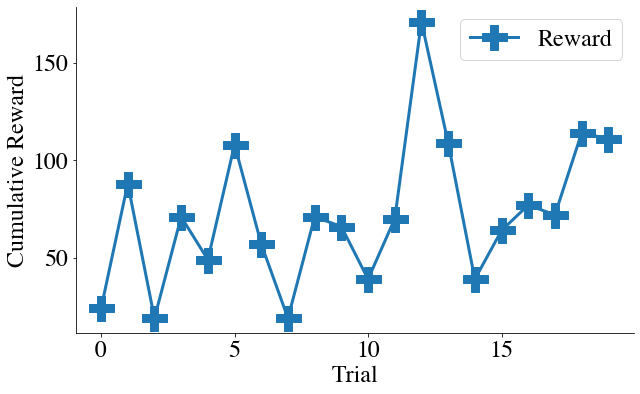

In [6]:
dir = "/Users/nato/Documents/Berkeley/Research/Codebases/mbrl-lib/exp_local/plotting_exs/single"
log_name = "MPC_earlywork.csv"
sub_dirs = os.listdir(dir)
# data level dirs have .hydra folder, where config can be loaded
# in mbrl.util.common load_hydra_cfg(results_dir: Union[str, pathlib.Path]) -> omegaconf.DictConfig:
assert '.hydra' in sub_dirs
import pandas as pd
df=pd.read_csv(dir+'/'+log_name, sep=',',header=0)
data = df.values
rews = data[:,0]
trials = data[:,-1]

plot_rewards_over_trials(rews, name=log_name, save=False)

## Plotting one experiment with seeds
This is the most common usage of the library -- plotting an algorithm with some control over random seeds, such as:
```
python algorithm.py -m mode=default seed=0,1,2,3,4
```

Rewards in this case is of shape (num_seed, num_trials). `mode=default` is added to circumvent a hydra / dir generations bug.


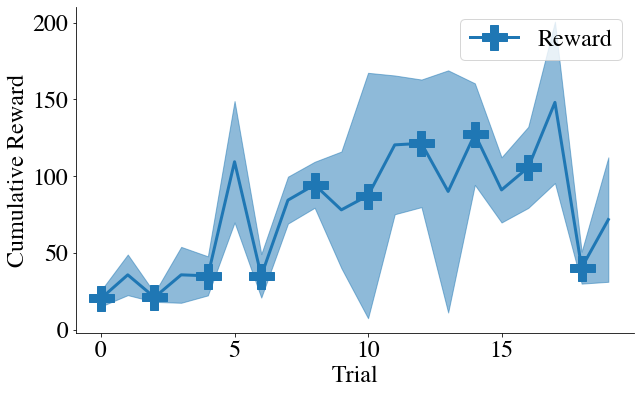

In [7]:
dir = "/Users/nato/Documents/Berkeley/Research/Codebases/mbrl-lib/exp_local/plotting_exs/seed_only"
log_name = "MPC_earlywork.csv"
sub_dirs = os.listdir(dir)

rewards = []
for d in sub_dirs:
    path = dir+'/'+d
    is_dir = os.path.isdir(path)
    if is_dir:
        rewards_dir = []
        seed_dirs = os.listdir(path)
        for s in seed_dirs:
            # this should be bottom level
            bottom_path = path+'/'+s
            files = os.listdir(bottom_path)
            assert '.hydra' in files
            df=pd.read_csv(bottom_path+'/'+log_name, sep=',',header=0)
            data = df.values
            rews = data[:,0].tolist()
            trials = data[:,-1].tolist()
            rewards_dir.append(rews)
        rewards.append(rewards_dir)

rewards = np.stack(rewards).squeeze()


plot_rewards_over_trials(rewards, name=log_name, save=False)

## Plotting multiple experiments with seeds
Full functionality. Plotting an algorithm with some control over random seeds and multiple experiments, such as:
```
python algorithm.py -m mode=default seed=0,1,2,3,4 optimizer=a,b,c
```

Rewards in this case is of shape (num_configs, num_seed, num_trials). Below, a line will be drawn for each optimizer.


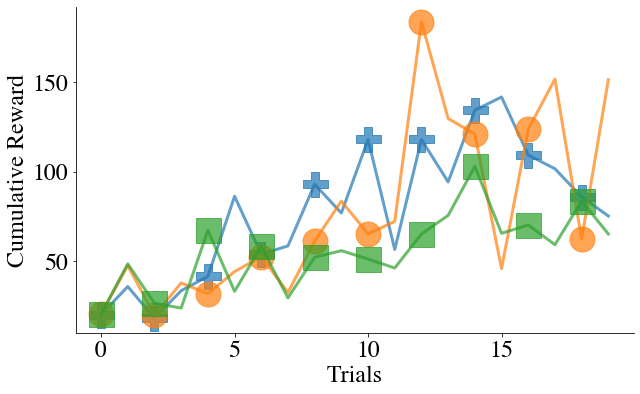

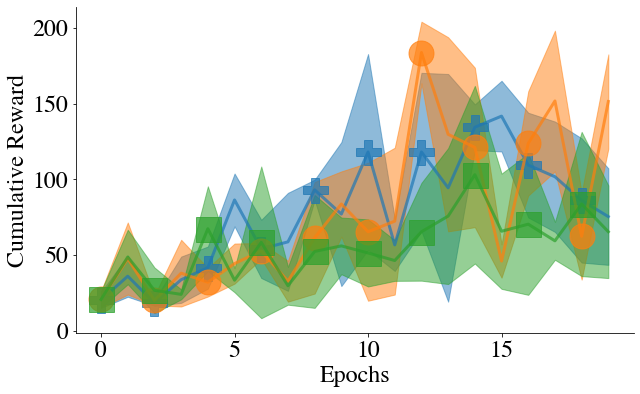

In [9]:
# example
dir = "/Users/nato/Documents/Berkeley/Research/Codebases/mbrl-lib/exp_local/plotting_exs/sweep_seeds"

log_name = "MPC_earlywork.csv"
sub_dirs = os.listdir(dir)

rewards = []
for d in sub_dirs:
    path = dir+'/'+d
    is_dir = os.path.isdir(path)
    if is_dir:
        rewards_dir = []
        seed_dirs = os.listdir(path)
        for s in seed_dirs:
            # this should be bottom level
            bottom_path = path+'/'+s
            files = os.listdir(bottom_path)
            assert '.hydra' in files
            df=pd.read_csv(bottom_path+'/'+log_name, sep=',',header=0)
            data = df.values
            rews = data[:,0].tolist()
            trials = data[:,-1].tolist()
            rewards_dir.append(rews)
        rewards.append(rewards_dir)

rewards = np.stack(rewards).squeeze()

plot_rewards_over_trials(rewards, name=log_name, save=False, legend=False, override_xaxis_name="Trials", error_bars=False)

plot_rewards_over_trials(rewards, name=log_name, save=False, legend=False, override_xaxis_name="Epochs", error_bars=True)

